In [23]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Používané zařízení: {device}")

Používané zařízení: cuda


In [24]:
from scipy.io import loadmat
import numpy as np
from pathlib import Path

dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists():
        dataset_path = alt
    else:
        raise FileNotFoundError(f"data.mat not found under {Path.cwd()} or its parent")

mat_data = loadmat(dataset_path)
print(mat_data.keys())


dict_keys(['__header__', '__version__', '__globals__', 'hB', 'souradniceGNSS', 'souradniceX', 'souradniceY', 'souradniceZ'])


In [25]:
import sys
import os

notebook_path = os.getcwd() 
print (f"Current notebook path: {notebook_path}")
project_root = os.path.dirname(notebook_path)
if project_root not in sys.path:
    sys.path.insert(0, project_root)
print (f"Added {project_root} to sys.path")

Current notebook path: /home/luky/skola/KalmanNet-for-state-estimation/TAN
Added /home/luky/skola/KalmanNet-for-state-estimation to sys.path


Vykresluji povrch terénu (může to chvíli trvat)...
...povrch vykreslen.


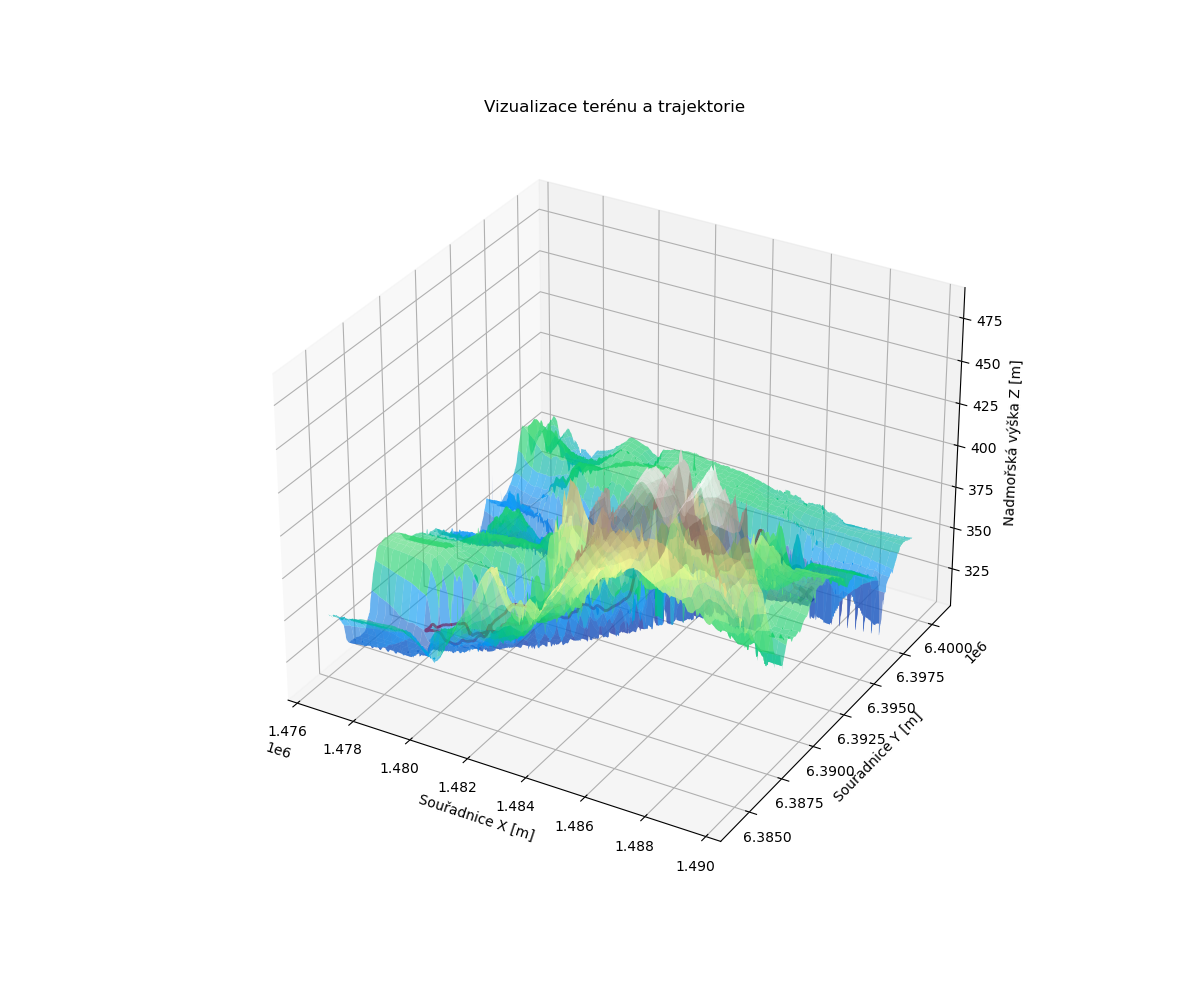

In [26]:
import matplotlib.pyplot as plt
from utils import trainer
from utils import utils
from Systems import DynamicSystem
import Filters

%matplotlib widget

try:

    souradniceX_mapa = mat_data['souradniceX']
    souradniceY_mapa = mat_data['souradniceY']
    souradniceZ_mapa = mat_data['souradniceZ']
    
    souradniceGNSS = mat_data['souradniceGNSS'] 

except KeyError as e:
    print(f"Chyba: Proměnná {e} nebyla nalezena v .mat souboru.")
    exit()


x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]
z_trajektorie = souradniceGNSS[2, :]


fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')


print("Vykresluji povrch terénu (může to chvíli trvat)...")
ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
                  rstride=50, cstride=50, 
                  cmap='terrain',      
                  alpha=0.6,          
                  label='Terén')
print("...povrch vykreslen.")


ax.plot(x_trajektorie, y_trajektorie, z_trajektorie, 
        'r-',             
        linewidth=2, 
        label='Trajektorie GNSS')


ax.plot([x_trajektorie[0]], [y_trajektorie[0]], [z_trajektorie[0]], 
        'go',             
        markersize=8, 
        label='Start')

ax.plot([x_trajektorie[-1]], [y_trajektorie[-1]], [z_trajektorie[-1]], 
        'kx',            
        markersize=10, 
        markeredgewidth=3,
        label='Cíl')



ax.set_xlabel('Souřadnice X [m]')
ax.set_ylabel('Souřadnice Y [m]')
ax.set_zlabel('Nadmořská výška Z [m]')
ax.set_title('Vizualizace terénu a trajektorie')
ax.grid(True)

plt.show()

In [ ]:
from scipy.io import loadmat
from scipy.interpolate import RegularGridInterpolator
mat_data = loadmat(dataset_path)

souradniceX_mapa = mat_data['souradniceX']
souradniceY_mapa = mat_data['souradniceY']
souradniceZ_mapa = mat_data['souradniceZ']
souradniceGNSS = mat_data['souradniceGNSS'] 

# --- KROK 1: Extrakce 1D os z 2D mřížek ---
# Získáme unikátní souřadnice pro osy X a Y.
# Pro osu X vezmeme první řádek z X matice.
# Pro osu Y vezmeme první sloupec z Y matice.
x_axis_unique = souradniceX_mapa[0, :]
y_axis_unique = souradniceY_mapa[:, 0]

print(f"Rozměry 1D osy X: {x_axis_unique.shape}")
print(f"Rozměry 1D osy Y: {y_axis_unique.shape}")
print(f"Rozměry 2D dat výšek Z: {souradniceZ_mapa.shape}")


# --- KROK 2: Vytvoření interpolačního objektu ---
# POZOR: Scipy očekává, že osy budou v pořadí (y, x), protože
# NumPy pole jsou indexována jako (řádek, sloupec), což odpovídá (y, x).
print("\nVytvářím interpolační funkci...")
terMap_interpolator = RegularGridInterpolator(
    (y_axis_unique, x_axis_unique),  # N-tice 1D os (nejprve Y, pak X)
    souradniceZ_mapa,
    bounds_error=False,  # NEVYHAZUJ CHYBU
    fill_value=np.nan
)
print("...interpolační funkce vytvořena.")

# --- KROK 3: Vytvoření finální, uživatelsky přívětivé funkce ---
def terMap(px, py):
    """
    Vypočítá nadmořskou výšku pro dané souřadnice (px, py)
    pomocí interpolace z mapy terénu.
    
    Funkce zvládne jak jednotlivé body, tak celé pole bodů.
    """
    # Spojíme vstupní body do formátu, kterému interpolátor rozumí:
    # pole o dvou sloupcích [y, x].
    points_to_query = np.column_stack((py, px))
    
    # Zavoláme interpolátor a vrátíme výsledek
    return terMap_interpolator(points_to_query)

In [ ]:
x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]

test_x_valid = x_trajektorie[0]
test_y_valid = y_trajektorie[0]
vyska_v_bode = terMap(test_x_valid, test_y_valid)
print(f"\nOčekávaná výška v bodě [{test_x_valid}, {test_y_valid}] je: {vyska_v_bode[0]:.2f} m")

# Příklad 2: Získání výšky terénu pod celou GNSS trajektorií
x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]
z_trajektorie_gnss = souradniceGNSS[2, :]

# Použijeme naši novou funkci k získání výšky terénu pod každým bodem trajektorie
z_terenu_pod_trajektorii = terMap(x_trajektorie, y_trajektorie)

# Ověření - vykreslení
plt.figure(figsize=(10, 6))
plt.plot(z_trajektorie_gnss, label='Nadmořská výška dle GNSS', linewidth=2)
plt.plot(z_terenu_pod_trajektorii, label='Nadmořská výška terénu (z naší funkce)', linestyle='--', linewidth=2)
plt.xlabel('Časový krok')
plt.ylabel('Nadmořská výška [m]')
plt.title('Ověření funkce terMap: Porovnání výšky GNSS a výšky terénu')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import torch
from math import pi

state_dim = 3
obs_dim = 1

F = torch.tensor([[1.0, 0.0, 0.0],
                       [0.0, 1.0, 0.0],
                       [0.0, 0.0, 0.96925]])

Q = torch.diag(torch.tensor([36.0, 36.0, 0.05]))
R = torch.tensor([[3.0]])
delta_pos = np.diff(souradniceGNSS[:2, :], axis=1)
u_pos = np.pad(delta_pos, ((0, 0), (0, 1)), 'constant')
u_bias = np.zeros((1, u_pos.shape[1]))
# Spojíme a převedeme na tensor
u_sequence_cpu = torch.from_numpy(np.vstack((u_pos, u_bias))).float()

# ### ZDE JE KLÍČOVÁ OPRAVA ###
# Přesuneme sekvenci vstupů na stejné zařízení jako model
u_sequence = u_sequence_cpu.to(device)

print(f"Tenzor u_sequence je nyní na zařízení: {u_sequence.device}")

# Počáteční podmínky
x_0 = torch.tensor([souradniceGNSS[0, 0], souradniceGNSS[1, 0], 0.0])
P_0 = torch.tensor([[25.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0],
                    [0.0, 0.0, 10.0]])

# Nelineární funkce měření h(x)
def h_nl(x: torch.Tensor) -> torch.Tensor:
    # ... (vaše funkce h_nl je již v pořádku, protože používá x.device) ...
    px = x[:, 0]
    py = x[:, 1]
    b = x[:, 2]
    vyska_terenu_np = terMap(px.detach().cpu().numpy(), py.detach().cpu().numpy())
    vyska_terenu = torch.from_numpy(vyska_terenu_np).float().to(x.device)
    result = vyska_terenu + b
    result_safe = result.clone()
    result_safe[torch.isnan(result)] = 1e9
    return result_safe.unsqueeze(1)

print("Vytvářím instanci DynamicSystem...")
system_model = DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h_nl,
    device=device  # Předáme definované zařízení
)
print("...objekt DynamicSystem byl úspěšně vytvořen.")
num_simulated_trajectories = 1
# ... zbytek vašeho kódu pro generování a zobrazení dat ...
# Nyní by měl proběhnout bez chyby, protože u_sequence je také na GPU.
x_generated, y_generated = utils.generate_data_with_input(
    system=system_model,
    num_trajectories=num_simulated_trajectories,
    u_sequence=u_sequence # Předáváme již přesunutý tenzor
)
# 3. Zobrazení výsledků
print(f"\nGenerování dat dokončeno.")
print(f"Rozměry vygenerovaných stavů 'x_generated': {x_generated.shape}")
print(f"Očekávaný tvar: [{num_simulated_trajectories}, {u_sequence.shape[1]}, {state_dim}]")
print(f"Rozměry vygenerovaných měření 'y_generated': {y_generated.shape}")
print(f"Očekávaný tvar: [{num_simulated_trajectories}, {u_sequence.shape[1]}, {obs_dim}]")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- Předpokládáme, že všechny proměnné z vašeho kódu již existují ---
# souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa
# souradniceGNSS
# x_generated (tensor o tvaru [5, 1276, 3])
# terMap (vaše interpolační funkce)

# --- Krok 1: Převod vygenerovaných dat z PyTorch tenzoru na NumPy pole ---
# .cpu() je pojistka pro případ, že by data byla na GPU
x_gen_np = x_generated.cpu().numpy()

# --- Krok 2: Vytvoření základního grafu (váš kód) ---
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

print("Vykresluji povrch terénu...")
ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
                  rstride=50, cstride=50, 
                  cmap='terrain',      
                  alpha=0.5, # Mírně průhlednější, aby byly vidět trajektorie
                  label='Terén')
print("...povrch vykreslen.")

# Vykreslení původní "pravdivé" GNSS trajektorie pro srovnání
x_trajektorie = souradniceGNSS[0, :]
y_trajektorie = souradniceGNSS[1, :]
z_trajektorie = souradniceGNSS[2, :]

ax.plot(x_trajektorie, y_trajektorie, z_trajektorie, 
        'r-',             
        linewidth=2.5, # Trochu tlustší, aby byla vidět
        label='Původní trajektorie (GNSS)')

# --- Krok 3: Vykreslení všech 5 vygenerovaných trajektorií ---
print(f"Vykresluji {num_simulated_trajectories} generovaných trajektorií...")

for i in range(num_simulated_trajectories):
    # Extrakce X a Y souřadnic pro i-tou trajektorii
    px_generated = x_gen_np[i, :, 0]
    py_generated = x_gen_np[i, :, 1]
    
    # !!! DŮLEŽITÉ: Výpočet Z souřadnice (nadmořské výšky) pomocí mapy !!!
    pz_generated = terMap(px_generated, py_generated)
    
    # Vykreslíme trajektorii. Label přidáme jen k první, aby nebyla legenda přeplněná.
    label_text = 'Generované trajektorie' if i == 0 else None
    
    ax.plot(px_generated, py_generated, pz_generated, 
            'b--', # Modrá přerušovaná čára
            linewidth=1.5, 
            label=label_text)

print("...vykreslování dokončeno.")
    
# --- Krok 4: Finalizace grafu (váš kód) ---
ax.plot([x_trajektorie[0]], [y_trajektorie[0]], [z_trajektorie[0]], 
        'go', markersize=8, label='Start (GNSS)')

ax.plot([x_trajektorie[-1]], [y_trajektorie[-1]], [z_trajektorie[-1]], 
        'kx', markersize=10, markeredgewidth=3, label='Cíl (GNSS)')

ax.set_xlabel('Souřadnice X [m]')
ax.set_ylabel('Souřadnice Y [m]')
ax.set_zlabel('Nadmořská výška Z [m]')
ax.set_title('Vizualizace terénu, GNSS a generovaných trajektorií')
ax.grid(True)
plt.show()

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# TODO PARTICLE FILTER NEPODPORUJE VSTUP AKTUALNE - UPRAVIT

# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 20 # Změňte zpět na 100 nebo kolik potřebujete
NUM_TEST_TRAJ = 1

# ==============================================================================
# 2. PŘÍPRAVA DAT (OPRAVENO)
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")

# ### ZDE JE KLÍČOVÁ OPRAVA ###
# Ořízneme u_sequence PŘED generováním dat.
u_sequence_test = u_sequence[:, :TEST_SEQ_LEN]

# Nyní předáme oříznutou sekvenci 'u', takže i 'x' a 'y' budou mít správnou délku.
x_test, y_test = utils.generate_data_with_input(
    system_model, 
    num_trajectories=NUM_TEST_TRAJ, 
    u_sequence=u_sequence_test
)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

print("y shape:", y_test.shape) # Mělo by být [1, 20, 1]
print("u shape:", u_sequence_test.shape) # Mělo by být [3, 20]
print("x shape:", x_test.shape) # Mělo by být [1, 20, 3]

# ==============================================================================
# 3. INICIALIZACE FILTRŮ
# ==============================================================================
ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=100000)

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA (OPRAVENO)
# ==============================================================================
all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []

print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        
        # ### ZDE JE KLÍČOVÁ OPRAVA ###
        # Použijeme stejnou, již oříznutou a připravenou u_sequence_test
        u_seq_gpu = u_sequence_test.to(device)

        # Nyní mají y_seq a u_sequence shodnou délku
        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu, 
            u_sequence=u_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu,u_sequence=u_seq_gpu, Ex0=system_model.Ex0,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideální model) dokončen pro trajektorii {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_ukf_ideal, anees_ukf_ideal = [], []

mse_pf_sir_ideal, anees_pf_sir_ideal = [], []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat, P_hat):
            # Délka pravdivé trajektorie
            true_len = x_true.shape[0]
            
            # Ořízneme odhady, aby měly stejnou délku jako pravdivá data.
            # Bereme prvních `true_len` prvků (tj. pro t=0 až t=299).
            x_hat_aligned = x_hat[:true_len]
            P_hat_aligned = P_hat[:true_len]
            
            # Nyní mají všechny tenzory shodnou délku
            mse = F.mse_loss(x_hat_aligned, x_true).item()
            anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat_aligned.unsqueeze(0), P_hat_aligned.unsqueeze(0))
            return mse, anees

        # Výpočty pro všechny modely
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
# print(f"{'PF (Nepřesný model)':<35} | {avg(mse_pf_mis):<20.4f} | {avg(anees_pf_mis):<20.4f}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
# print(f"{'PF (Ideální model)':<35} | {avg(mse_pf_ideal):<20.4f} | {avg(anees_pf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideální model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x_true_plot = all_x_true_cpu[0].numpy()
x_ukf_plot = all_x_hat_ukf_ideal_cpu[0].numpy()

fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
                  rstride=50, cstride=50, cmap='terrain', alpha=0.5)

px_true = x_true_plot[:, 0]
py_true = x_true_plot[:, 1]
pz_true = terMap(px_true, py_true)
ax.plot(px_true, py_true, pz_true, 'r-', linewidth=3, label='Referenční trajektorie')

px_ukf = x_ukf_plot[:, 0]
py_ukf = x_ukf_plot[:, 1]
pz_ukf = terMap(px_ukf, py_ukf)
ax.plot(px_ukf, py_ukf, pz_ukf, 'g--', linewidth=3, label='Odhad UKF')

ax.plot([px_true[0]], [py_true[0]], [pz_true[0]], 
        'o', color='black', markersize=10, label='Start')

ax.set_xlabel('Souřadnice X [m]')
ax.set_ylabel('Souřadnice Y [m]')
ax.set_zlabel('Nadmořská výška Z [m]')
ax.set_title('Porovnání referenční trajektorie a odhadu UKF')
ax.legend()
ax.grid(True)
plt.show()

# 4D model


In [ ]:
import torch
from math import pi

state_dim = 4
obs_dim = 3
dT = 1
q = 1

F = torch.tensor([[1.0, 0.0, dT, 0.0],
                   [0.0, 1.0, 0.0, dT],
                   [0.0, 0.0, 1.0, 0.0],
                   [0.0, 0.0, 0.0, 1.0]])

Q = q* torch.tensor([[dT**3/3, 0.0, dT**2/2, 0.0],
                   [0.0, dT**3/3, 0.0, dT**2/2],
                   [dT**2/2, 0.0, dT, 0.0],
                   [0.0, dT**2/2, 0.0, dT]])
R = torch.tensor([[3.0**2, 0.0, 0.0],
                   [0.0, 1.0**2, 0.0],
                   [0.0, 0.0, 1.0**2]])

initial_velocity_np = souradniceGNSS[:2, 1] - souradniceGNSS[:2, 0]
initial_velocity = torch.from_numpy(initial_velocity_np)

initial_position = torch.from_numpy(souradniceGNSS[:2, 0])
x_0 = torch.cat([
    initial_position,
    initial_velocity
]).float()

P_0 = torch.tensor([[25.0, 0.0, 0.0, 0.0],
                    [0.0, 25.0, 0.0, 0.0],
                    [0.0, 0.0, 0.5, 0.0],
                    [0.0, 0.0, 0.0, 0.5]])

# Nelineární funkce měření h(x)
def h(x: torch.Tensor) -> torch.Tensor:
    eps = 1e-12
    # _w reprezentuje world frame
    px_w = x[:, 0]
    py_w = x[:, 1]
    vx_w = x[:, 2]
    vy_w = x[:, 3]
    norm_v_w = torch.sqrt(vx_w**2+vy_w**2)
    vx_b = vx_w**2/(norm_v_w+eps)-vy_w**2/(norm_v_w+eps)
    vy_b = (vy_w*vx_w)/(norm_v_w+eps) + (vx_w*vy_w)/(norm_v_w+eps)
    vyska_terenu_np = terMap(px_w.detach().cpu().numpy(), py_w.detach().cpu().numpy())
    vyska_terenu = torch.from_numpy(vyska_terenu_np).float().to(x.device)
    if torch.isnan(vyska_terenu).any():
        print("Varování: NaN hodnoty ve výšce terénu detekovány!")
    vyska_terenu[torch.isnan(vyska_terenu)] = 1e9 # Nahradíme NaN velkým číslem

    # Spojíme tři vektory (každý o délce N) do matice [N, 3]
    result = torch.stack([vyska_terenu, vx_b, vy_b], dim=1)
    
    return result

print("Vytvářím instanci DynamicSystem...")
system_model = DynamicSystem(
    state_dim=state_dim,
    obs_dim=obs_dim,
    Q=Q.float(),
    R=R.float(),
    Ex0=x_0.float(),
    P0=P_0.float(),
    F=F.float(),
    h=h,
    device=device  # Předáme definované zařízení
)

In [ ]:
TRAIN_SEQ_LEN = 10      # Krátké sekvence pro stabilní trénink (TBPTT)
VALID_SEQ_LEN = 30      # Stejná délka pro konzistentní validaci
TEST_SEQ_LEN = 200      # Dlouhé sekvence pro testování generalizace

NUM_TRAIN_TRAJ = 500   # Hodně trénovacích příkladů
NUM_VALID_TRAJ = 200    # Dostatek pro spolehlivou validaci
NUM_TEST_TRAJ = 100     # Pro robustní vyhodnocení

BATCH_SIZE = 16         # Dobrý kompromis

x_train, y_train = utils.generate_data_for_map(system_model, num_trajectories=NUM_TRAIN_TRAJ, seq_len=TRAIN_SEQ_LEN)
x_val, y_val = utils.generate_data_for_map(system_model, num_trajectories=NUM_VALID_TRAJ, seq_len=VALID_SEQ_LEN)
x_test, y_test = utils.generate_data_for_map(system_model, num_trajectories=1, seq_len=TEST_SEQ_LEN)

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:

# ==============================================================================
# 1. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = 400 # Změňte zpět na 100 nebo kolik potřebujete
NUM_TEST_TRAJ = 1
J_SAMPLES_TEST = 25

# ==============================================================================
# 2. PŘÍPRAVA DAT (OPRAVENO)
# ==============================================================================
print(f"\nGeneruji {NUM_TEST_TRAJ} testovacích trajektorií o délce {TEST_SEQ_LEN}...")

# Nyní předáme oříznutou sekvenci 'u', takže i 'x' a 'y' budou mít správnou délku.
x_test, y_test = utils.generate_data_for_map(
    system_model, 
    num_trajectories=NUM_TEST_TRAJ,
    seq_len=TEST_SEQ_LEN
)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Generování dat dokončeno.")

print("y shape:", y_test.shape) # Mělo by být [1, 20, 1]
print("x shape:", x_test.shape) # Mělo by být [1, 20, 3]


In [ ]:

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import random
import csv
from datetime import datetime
import pandas as pd
from copy import deepcopy
from state_NN_models import StateKalmanNet

# Nastavení seedu pro reprodukovatelnost tohoto běhu
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)
state_knet = StateKalmanNet(system_model, device=device, hidden_size_multiplier=12).to(device)
print(state_knet)
trainer.train_state_KalmanNet(
    model=state_knet, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    device=device, 
    epochs=200, 
    lr=1e-4,
    early_stopping_patience=50,
    clip_grad=10
)

In [ ]:
# import torch
# import torch.nn as nn
# from torch.utils.data import TensorDataset, DataLoader
# from state_NN_models import StateBayesianKalmanNet
# import numpy as np
# import os
# import random
# import csv
# from datetime import datetime
# import pandas as pd
# from copy import deepcopy

# model_config = {
#     "hidden_size_multiplier": 10,
#     "output_layer_multiplier": 4,
#     "num_gru_layers": 1,
#     "init_min_dropout": 0.5,
#     "init_max_dropout": 0.8
# }

# train_config = {
#     "total_train_iter": 1200,
#     "learning_rate": 1e-4,
#     "clip_grad": 10.0,
#     "J_samples": 20,
#     "validation_period": 20,
#     "logging_period": 20,
#     "warmup_iterations":0 # Trénuj prvních 400 iterací jen na MSE
# }

# # =================================================================================
# # KROK 3: SPUŠTĚNÍ JEDNOHO TRÉNINKOVÉHO BĚHU
# # =================================================================================

# print("="*80)
# print("Spouštím jeden plnohodnotný tréninkový běh...")
# print(f"Parametry modelu: {model_config}")
# print(f"Parametry tréninku: {train_config}")
# print("="*80)

# # Nastavení seedu pro reprodukovatelnost tohoto běhu
# torch.manual_seed(42)
# np.random.seed(42)
# random.seed(42)

# # Vytvoření modelu
# state_bkn_knet = StateBayesianKalmanNet(
#     system_model,
#     device=device,
#     **model_config
# ).to(device)

# # Spuštění tréninku
# # Používáme `run_training_session`, která vrací slovník s výsledky
# results = trainer.training_session_trajectory_with_gaussian_nll_training_fcn(model=state_bkn_knet,
#     train_loader=train_loader,
#     val_loader=val_loader,
#     device=device,
#     **train_config
# )

# # `run_training_session` automaticky načte nejlepší model zpět,
# # takže `state_bkn_knet` nyní obsahuje váhy nejlepšího modelu.
# trained_model = results['final_model']

# print("\n" + "="*80)
# print("TRÉNINK DOKONČEN - FINÁLNÍ VÝSLEDKY Z NEJLEPŠÍHO MODELU")
# print("="*80)
# print(f"Nejlepší model byl nalezen v iteraci: {results['best_iter']}")
# # --- Změněné klíče, aby odpovídaly return statementu ---
# print(f"Nejlepší dosažený validační ANEES: {results['best_val_anees']:.4f}")
# print("--- Metriky odpovídající tomuto nejlepšímu modelu ---")
# print(f"  MSE na validační sadě:       {results['best_val_mse']:.4f}")
# print(f"  NLL na validační sadě:       {results['best_val_nll']:.4f}")
# print("="*80)

# print(trained_model)
# # Nyní můžeš s `trained_model` pokračovat, například ho vyhodnotit na testovací sadě.

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader


# ==============================================================================
# 3. INICIALIZACE FILTRŮ
# ==============================================================================
ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=100000)

# ==============================================================================
# 4. VYHODNOCOVACÍ SMYČKA (OPRAVENO)
# ==============================================================================
all_x_true_cpu = []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []
all_x_hat_classic_knet_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []

print(f"\nVyhodnocuji modely na {NUM_TEST_TRAJ} testovacích trajektoriích...")

state_knet.eval()


with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)

        # # --- A. Bayesian KalmanNet (Trajectory-wise) ---
        # ensemble_trajectories = []
        # for j in range(J_SAMPLES_TEST):
        #     state_bkn_knet.reset(batch_size=1, initial_state=initial_state)
        #     current_x_hats = []
        #     for t in range(1, TEST_SEQ_LEN):
        #         x_filtered_t, _ = state_bkn_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
        #         current_x_hats.append(x_filtered_t)
        #     ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        # ensemble = torch.stack(ensemble_trajectories, dim=0)
        # predictions_bkn = ensemble.mean(dim=0)
        # diff = ensemble - predictions_bkn.unsqueeze(0)
        # covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        # full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        # full_P_hat_bkn = torch.cat([system_model.P0.unsqueeze(0), covariances_bkn], dim=0)


        # --- B. Klasický StateKalmanNet (pouze MSE) ---
        state_knet.reset(batch_size=1, initial_state=initial_state)
        classic_knet_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = state_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet_preds.append(x_filtered_t)
        full_x_hat_classic_knet = torch.cat([initial_state, torch.cat(classic_knet_preds, dim=0)], dim=0)
        

        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']

        pf_sir_i_res = pf_sir_ideal.process_sequence(y_test_seq_gpu, Ex0=system_model.Ex0,P0=system_model.P0)
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        full_particles_history_pf_sir_i = pf_sir_i_res['particles_history']
        print(f"PF-SIR (ideální model) dokončen pro trajektorii {i + 1}/{NUM_TEST_TRAJ}.")

        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        # all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_classic_knet_cpu.append(full_x_hat_classic_knet.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"Dokončena trajektorie {i + 1}/{NUM_TEST_TRAJ}...")

# ==============================================================================
# 5. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
# Seznamy pro sběr metrik
mse_bkn, anees_bkn = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []; mse_classic_knet = []

mse_pf_sir_ideal, anees_pf_sir_ideal = [], []

print("\nPočítám finální metriky pro jednotlivé trajektorie...")

with torch.no_grad():
    for i in range(NUM_TEST_TRAJ):
        x_true = all_x_true_cpu[i]
        def get_metrics(x_hat, P_hat):
            # Délka pravdivé trajektorie
            true_len = x_true.shape[0]
            
            # Ořízneme odhady, aby měly stejnou délku jako pravdivá data.
            # Bereme prvních `true_len` prvků (tj. pro t=0 až t=299).
            x_hat_aligned = x_hat[:true_len]
            P_hat_aligned = P_hat[:true_len]
            
            # Nyní mají všechny tenzory shodnou délku
            mse = F.mse_loss(x_hat_aligned, x_true).item()
            anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat_aligned.unsqueeze(0), P_hat_aligned.unsqueeze(0))
            return mse, anees

        # Výpočty pro všechny modely
        # mse, anees = get_metrics(all_x_hat_bkn_cpu[i], all_P_hat_bkn_cpu[i]); mse_bkn.append(mse); anees_bkn.append(anees)
        mse = F.mse_loss(all_x_hat_classic_knet_cpu[i][1:], x_true[1:]).item(); mse_classic_knet.append(mse)
        mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[i], all_P_hat_ukf_ideal_cpu[i]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
        mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[i], all_P_hat_pf_sir_ideal_cpu[i]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)
      
def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])
state_dim_for_nees = all_x_true_cpu[0].shape[1]

# --- Finální výpis tabulky ---
print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (průměr přes {NUM_TEST_TRAJ} běhů)")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
print("-" * 80)
print(f"{'--- Model-Based Filters ---':<35} | {'':<20} | {'':<20}")
# print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
print(f"{'KNet (pouze MSE)':<35} | {avg(mse_classic_knet):<20.4f} | {'N/A':<20}")
# print(f"{'PF (Nepřesný model)':<35} | {avg(mse_pf_mis):<20.4f} | {avg(anees_pf_mis):<20.4f}")
print("-" * 80)
print(f"{'--- Benchmarks ---':<35} | {'':<20} | {'':<20}")
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
# print(f"{'PF (Ideální model)':<35} | {avg(mse_pf_ideal):<20.4f} | {avg(anees_pf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideální model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)

# Test na skutečné trajektorii


In [31]:
import torch
import torch.nn.functional as F
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from scipy.io import loadmat
from pathlib import Path

# ==============================================================================
# 1. NAČTENÍ ZDROJOVÝCH DAT Z .MAT SOUBORU
# ==============================================================================
# Tento blok zajistí, že proměnné hB a souradniceGNSS budou vždy definovány.
dataset_path = Path('data') / 'data.mat'
if not dataset_path.exists():
    # Pokus o alternativní cestu, pokud běžíte z podadresáře
    alt = Path.cwd().parent / 'data' / 'data.mat'
    if alt.exists(): dataset_path = alt
    else: raise FileNotFoundError("Soubor data.mat nebyl nalezen.")

mat_data = loadmat(dataset_path)
hB = mat_data['hB']
souradniceGNSS = mat_data['souradniceGNSS']
print("Zdrojová data z .mat souboru úspěšně načtena.")

# ==============================================================================
# 2. KONFIGURACE TESTU
# ==============================================================================
TEST_SEQ_LEN = souradniceGNSS.shape[1]
NUM_TEST_TRAJ = 1
J_SAMPLES_TEST = 25

# ==============================================================================
# 3. PŘÍPRAVA REÁLNÝCH TESTOVACÍCH DAT
# ==============================================================================
print(f"\nPřipravuji reálná testovací data o délce {TEST_SEQ_LEN}...")

# --- A. Příprava "Ground Truth" stavové trajektorie (x_true) ---
gnss_pos = torch.from_numpy(souradniceGNSS[:2, :]).float()
gnss_vel = torch.diff(gnss_pos, dim=1)
gnss_vel = torch.cat([gnss_vel, gnss_vel[:, -1].unsqueeze(1)], dim=1)
x_test_true = torch.cat([gnss_pos.T, gnss_vel.T], dim=1).unsqueeze(0)

# --- B. Příprava sekvence měření (y_meas) ---
y_barometer = torch.from_numpy(hB).float().T
vx_w, vy_w = gnss_vel[0, :], gnss_vel[1, :]
norm_v_w = torch.sqrt(vx_w**2 + vy_w**2).clamp(min=1e-6)
vx_b = (vx_w**2 - vy_w**2) / norm_v_w
vy_b = (2 * vx_w * vy_w) / norm_v_w
y_odometer = torch.stack([vx_b, vy_b], dim=1)
y_test_meas = torch.cat([y_barometer, y_odometer], dim=1).unsqueeze(0)

# --- C. Vytvoření DataLoaderu ---
test_dataset = TensorDataset(x_test_true, y_test_meas)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
print("Příprava reálných dat dokončena.")
print("Tvar měření (y_test_meas):", y_test_meas.shape)
print("Tvar skutečného stavu (x_test_true):", x_test_true.shape)

# ==============================================================================
# 4. INICIALIZACE FILTRŮ
# ==============================================================================
# Předpokládáme, že system_model, state_knet, atd. jsou již definovány
ukf_ideal = Filters.UnscentedKalmanFilter(system_model)
pf_sir_ideal = Filters.ParticleFilter(system_model, num_particles=100000)

# ==============================================================================
# 5. VYHODNOCOVACÍ SMYČKA
# ==============================================================================
# ... (zbytek vašeho skriptu odsud dál je již správný a není třeba ho měnit) ...
all_x_true_cpu, all_y_meas_cpu = [], []
all_x_hat_ukf_ideal_cpu, all_P_hat_ukf_ideal_cpu = [], []
all_x_hat_pf_sir_ideal_cpu, all_P_hat_pf_sir_ideal_cpu = [], []
all_x_hat_classic_knet_cpu = []
all_x_hat_bkn_cpu, all_P_hat_bkn_cpu = [], []

print(f"\nVyhodnocuji modely na reálné trajektorii...")

state_knet.eval()
# state_bkn_knet.eval()

with torch.no_grad():
    for i, (x_true_seq_batch, y_test_seq_batch) in enumerate(test_loader):
        y_test_seq_gpu = y_test_seq_batch.squeeze(0).to(device)
        x_true_seq_gpu = x_true_seq_batch.squeeze(0).to(device)
        initial_state = x_true_seq_gpu[0, :].unsqueeze(0)

        # --- A. Bayesian KalmanNet (BKN) ---
        # print("Spouštím Bayesian KalmanNet...")
        # ensemble_trajectories = []
        # for j in range(J_SAMPLES_TEST):
        #     state_bkn_knet.reset(batch_size=1, initial_state=initial_state)
        #     current_x_hats = []
        #     for t in range(1, TEST_SEQ_LEN):
        #         x_filtered_t, _ = state_bkn_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
        #         current_x_hats.append(x_filtered_t)
        #     ensemble_trajectories.append(torch.cat(current_x_hats, dim=0))
        # ensemble = torch.stack(ensemble_trajectories, dim=0)
        # predictions_bkn = ensemble.mean(dim=0)
        # diff = ensemble - predictions_bkn.unsqueeze(0)
        # covariances_bkn = (diff.unsqueeze(-1) @ diff.unsqueeze(-2)).mean(dim=0)
        # full_x_hat_bkn = torch.cat([initial_state, predictions_bkn], dim=0)
        # full_P_hat_bkn = torch.cat([system_model.P0.unsqueeze(0), covariances_bkn], dim=0)
        # print("...BKN dokončen.")

        # --- B. Klasický StateKalmanNet (KNet) ---
        print("Spouštím klasický KalmanNet...")
        state_knet.reset(batch_size=1, initial_state=initial_state)
        classic_knet_preds = []
        for t in range(1, TEST_SEQ_LEN):
            x_filtered_t = state_knet.step(y_test_seq_gpu[t, :].unsqueeze(0))
            classic_knet_preds.append(x_filtered_t)
        full_x_hat_classic_knet = torch.cat([initial_state, torch.cat(classic_knet_preds, dim=0)], dim=0)
        print("...KNet dokončen.")

        # --- C. Unscented Kalman Filter (UKF) ---
        print("Spouštím Unscented Kalman Filter...")
        ukf_i_res = ukf_ideal.process_sequence(
            y_seq=y_test_seq_gpu,
            Ex0=system_model.Ex0, 
            P0=system_model.P0
        )
        full_x_hat_ukf_i = ukf_i_res['x_filtered']
        full_P_hat_ukf_i = ukf_i_res['P_filtered']
        print("...UKF dokončen.")

        # --- D. Particle Filter (PF-SIR) ---
        print("Spouštím Particle Filter...")
        pf_sir_i_res = pf_sir_ideal.process_sequence(
            y_seq=y_test_seq_gpu, 
            Ex0=system_model.Ex0,
            P0=system_model.P0
        )
        full_x_hat_pf_sir_i = pf_sir_i_res['x_filtered']
        full_P_hat_pf_sir_i = pf_sir_i_res['P_filtered']
        print("...PF-SIR dokončen.")

        # Uložení všech výsledků na CPU pro finální výpočty
        all_x_true_cpu.append(x_true_seq_gpu.cpu())
        all_y_meas_cpu.append(y_test_seq_gpu.cpu())
        # all_x_hat_bkn_cpu.append(full_x_hat_bkn.cpu()); all_P_hat_bkn_cpu.append(full_P_hat_bkn.cpu())
        all_x_hat_classic_knet_cpu.append(full_x_hat_classic_knet.cpu())
        all_x_hat_ukf_ideal_cpu.append(full_x_hat_ukf_i.cpu()); all_P_hat_ukf_ideal_cpu.append(full_P_hat_ukf_i.cpu())
        all_x_hat_pf_sir_ideal_cpu.append(full_x_hat_pf_sir_i.cpu()); all_P_hat_pf_sir_ideal_cpu.append(full_P_hat_pf_sir_i.cpu())
        print(f"\nVyhodnocení dokončeno.")

# ==============================================================================
# 6. FINÁLNÍ VÝPOČET A VÝPIS METRIK
# ==============================================================================
mse_bkn, anees_bkn = [], []; mse_ukf_ideal, anees_ukf_ideal = [], []; mse_classic_knet = []
mse_pf_sir_ideal, anees_pf_sir_ideal = [], []

print("\nPočítám finální metriky...")
with torch.no_grad():
    x_true = all_x_true_cpu[0]
    def get_metrics(x_hat, P_hat):
        mse = F.mse_loss(x_hat, x_true).item()
        anees = utils.calculate_anees_vectorized(x_true.unsqueeze(0), x_hat.unsqueeze(0), P_hat.unsqueeze(0))
        return mse, anees

    # mse, anees = get_metrics(all_x_hat_bkn_cpu[0], all_P_hat_bkn_cpu[0]); mse_bkn.append(mse); anees_bkn.append(anees)
    mse = F.mse_loss(all_x_hat_classic_knet_cpu[0][1:], x_true[1:]).item(); mse_classic_knet.append(mse)
    mse, anees = get_metrics(all_x_hat_ukf_ideal_cpu[0], all_P_hat_ukf_ideal_cpu[0]); mse_ukf_ideal.append(mse); anees_ukf_ideal.append(anees)
    mse, anees = get_metrics(all_x_hat_pf_sir_ideal_cpu[0], all_P_hat_pf_sir_ideal_cpu[0]); mse_pf_sir_ideal.append(mse); anees_pf_sir_ideal.append(anees)

def avg(metric_list): return np.mean([m for m in metric_list if not np.isnan(m)])

print("\n" + "="*80)
print(f"FINÁLNÍ VÝSLEDKY (test na reálných datech, T={TEST_SEQ_LEN})")
print("="*80)
print(f"{'Model':<35} | {'Průměrné MSE':<20} | {'Průměrný ANEES':<20}")
print("-" * 80)
# print(f"{'Bayesian KNet (BKN)':<35} | {avg(mse_bkn):<20.4f} | {avg(anees_bkn):<20.4f}")
print(f"{'KNet (pouze MSE)':<35} | {avg(mse_classic_knet):<20.4f} | {'N/A':<20}")
print("-" * 80)
print(f"{'UKF (Ideální model)':<35} | {avg(mse_ukf_ideal):<20.4f} | {avg(anees_ukf_ideal):<20.4f}")
print(f"{'PF-SIR (Ideální model)':<35} | {avg(mse_pf_sir_ideal):<20.4f} | {avg(anees_pf_sir_ideal):<20.4f}")
print("="*80)

Zdrojová data z .mat souboru úspěšně načtena.

Připravuji reálná testovací data o délce 1276...
Příprava reálných dat dokončena.
Tvar měření (y_test_meas): torch.Size([1, 1276, 3])
Tvar skutečného stavu (x_test_true): torch.Size([1, 1276, 4])

Vyhodnocuji modely na reálné trajektorii...
Spouštím klasický KalmanNet...
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce terénu detekovány!
Varování: NaN hodnoty ve výšce 

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # --- Předpokládáme, že tyto proměnné již existují z vašeho vyhodnocení ---
# # all_x_true_cpu: Seznam s pravdivou trajektorií
# # full_x_hat_classic_knet: Tenzor s odhady z klasického KNetu
# # full_x_hat_bkn: Tenzor s odhady z Bayesian KNetu (předpoklad)
# # souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa: Data mapy
# # terMap: Vaše interpolační funkce

# # --- Krok 1: Příprava dat ---
# x_true_plot = all_x_true_cpu[0].numpy()
# x_knet_plot = full_x_hat_classic_knet.cpu().numpy()

# # ### PŘIDÁNO: Příprava dat pro BKN ###
# # Ujistěte se, že proměnná 'full_x_hat_bkn' existuje a obsahuje výsledky BKN
# x_bkn_plot = full_x_hat_bkn.cpu().numpy()

# print(f"Tvar skutečné trajektorie: {x_true_plot.shape}")
# print(f"Tvar odhadnuté trajektorie (KNet): {x_knet_plot.shape}")
# print(f"Tvar odhadnuté trajektorie (BKN): {x_bkn_plot.shape}")


# # --- Krok 2: Vytvoření 3D grafu ---
# fig = plt.figure(figsize=(14, 12))
# ax = fig.add_subplot(111, projection='3d')

# # Vykreslení povrchu terénu (volitelné)
# # ax.plot_surface(souradniceX_mapa, souradniceY_mapa, souradniceZ_mapa, 
# #                   rstride=100, cstride=100, cmap='terrain', alpha=0.3)

# # --- Krok 3: Vykreslení trajektorií ---

# # A. Skutečná (referenční) trajektorie
# px_true = x_true_plot[:, 0]
# py_true = x_true_plot[:, 1]
# pz_true = terMap(px_true, py_true)
# ax.plot(px_true, py_true, pz_true, 'r-', linewidth=3, label='Referenční trajektorie')

# # B. Odhadnutá trajektorie z KalmanNetu
# px_knet = x_knet_plot[:, 0]
# py_knet = x_knet_plot[:, 1]
# pz_knet = terMap(px_knet, py_knet)
# ax.plot(px_knet, py_knet, pz_knet, 'g--', linewidth=3, label='Odhad KNet')

# # ### PŘIDÁNO: Vykreslení trajektorie z Bayesian KNetu ###
# # C. Odhadnutá trajektorie z Bayesian KNetu
# px_bkn = x_bkn_plot[:, 0]
# py_bkn = x_bkn_plot[:, 1]
# pz_bkn = terMap(px_bkn, py_bkn) # Dopočítáme Z souřadnici
# ax.plot(px_bkn, py_bkn, pz_bkn, 'b:', linewidth=3, label='Odhad BKN') # Modrá tečkovaná čára


# # --- Krok 4: Finalizace grafu ---
# ax.plot([px_true[0]], [py_true[0]], [pz_true[0]], 
#         'o', color='black', markersize=10, label='Start')

# ax.set_xlabel('Souřadnice X [m]')
# ax.set_ylabel('Souřadnice Y [m]')
# ax.set_zlabel('Nadmořská výška Z [m]')

# # Upravíme název, aby zahrnoval všechny modely
# ax.set_title('Porovnání referenční trajektorie a odhadů KNet/BKN') 
# ax.legend()
# ax.grid(True)

# ax.view_init(elev=30., azim=-60)

# plt.show()

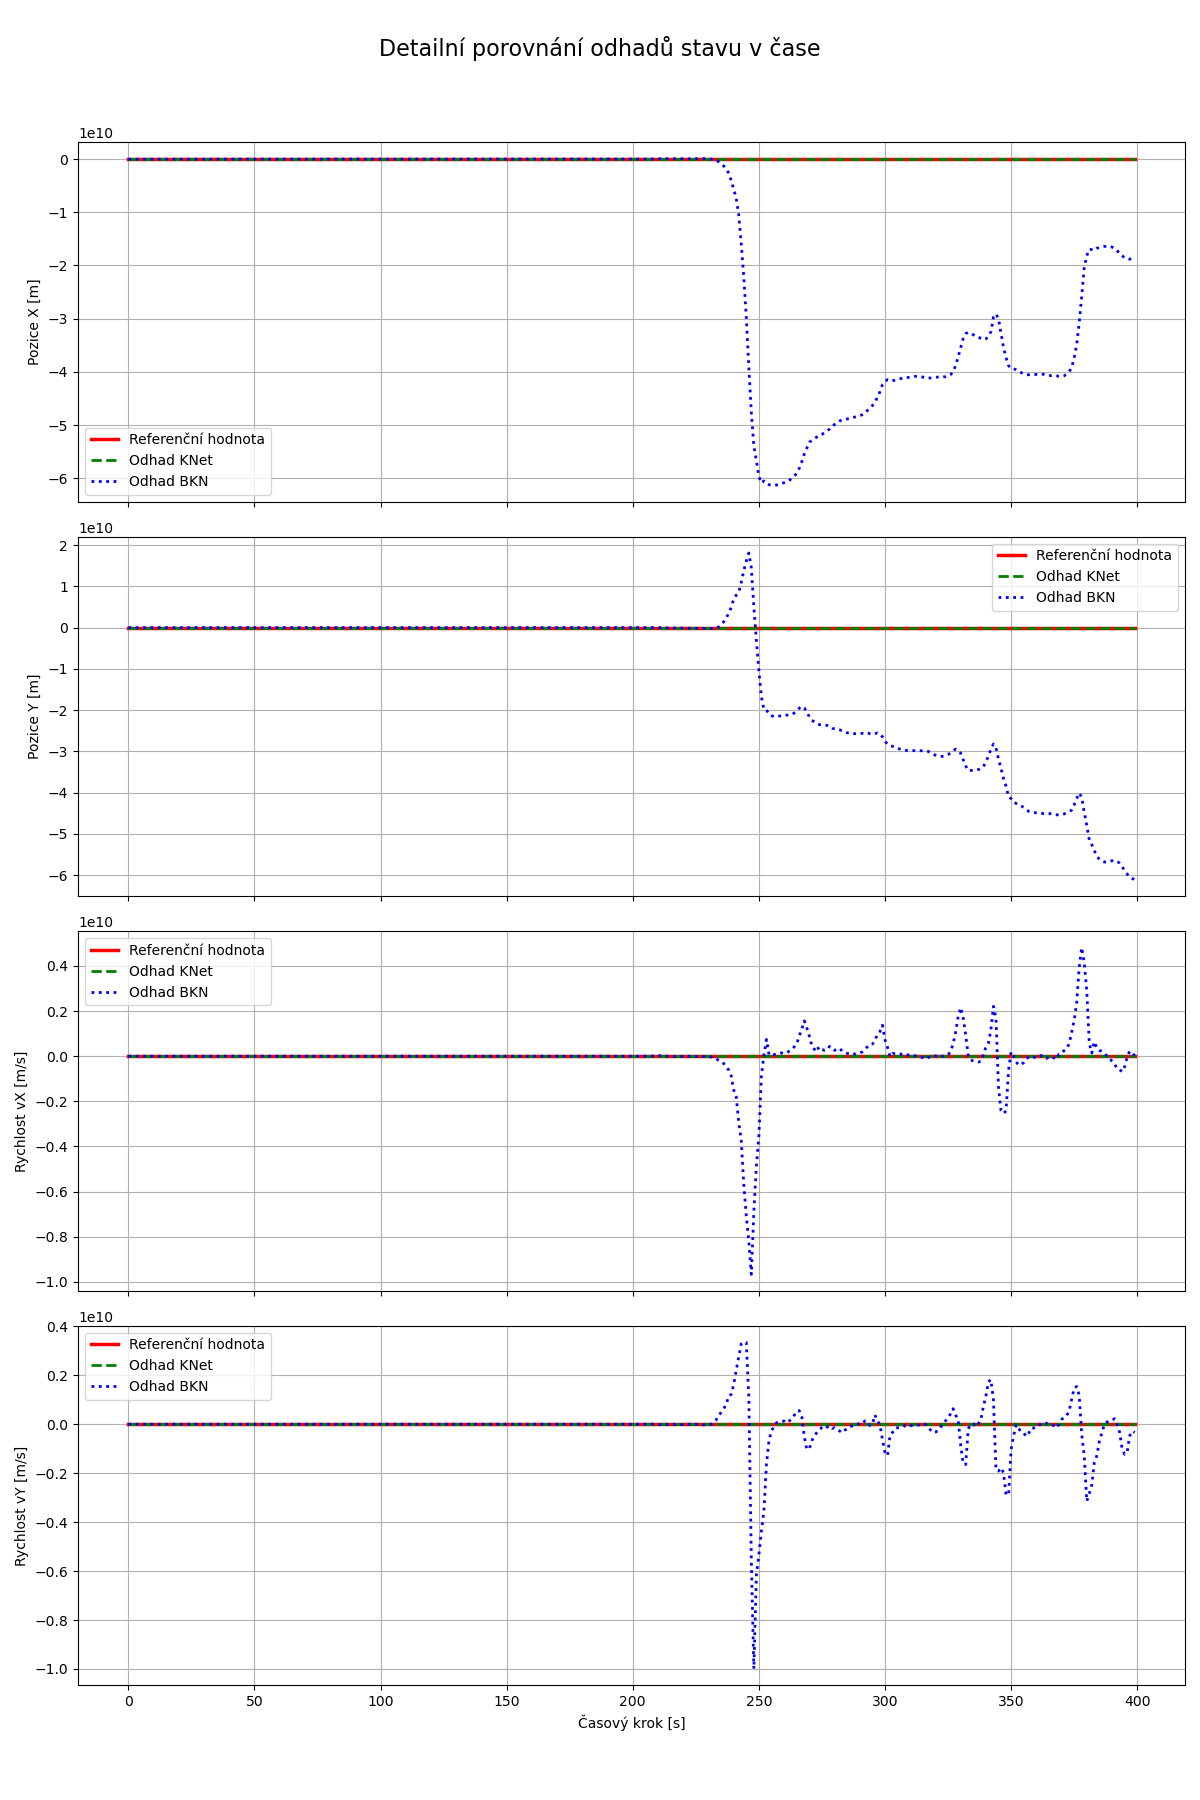

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# ==============================================================================
# 1. PŘÍPRAVA DAT (stejná jako předtím)
# ==============================================================================
# Předpokládáme, že tyto proměnné již existují z vašeho vyhodnocení
# all_x_true_cpu, full_x_hat_classic_knet, full_x_hat_bkn

x_true_plot = all_x_true_cpu[0].numpy()
x_knet_plot = full_x_hat_classic_knet.cpu().numpy()
x_bkn_plot = full_x_hat_bkn.cpu().numpy()

# Vytvoříme časovou osu pro osu X grafů
num_steps = x_true_plot.shape[0]
time_axis = np.arange(num_steps)

# Seznam názvů pro jednotlivé složky stavu (pro popisky os)
state_labels = [
    'Pozice X [m]',
    'Pozice Y [m]',
    'Rychlost vX [m/s]',
    'Rychlost vY [m/s]'
]

# ==============================================================================
# 2. VYTVOŘENÍ 4x1 SUBPLOT GRAFU
# ==============================================================================
# fig, axes = plt.subplots(počet_řádků, počet_sloupců, ... )
fig, axes = plt.subplots(4, 1, figsize=(12, 18), sharex=True)
fig.suptitle('Detailní porovnání odhadů stavu v čase', fontsize=16)

# Smyčka přes všechny 4 složky stavu
for i in range(4):
    ax = axes[i] # Vybereme aktuální podgraf (osu)

    # A. Vykreslení skutečné (referenční) hodnoty
    ax.plot(time_axis, x_true_plot[:, i], 'r-', linewidth=2.5, label='Referenční hodnota')

    # B. Vykreslení odhadu z klasického KNetu
    ax.plot(time_axis, x_knet_plot[:, i], 'g--', linewidth=2, label='Odhad KNet')
    
    # C. Vykreslení odhadu z Bayesian KNetu
    ax.plot(time_axis, x_bkn_plot[:, i], 'b:', linewidth=2, label='Odhad BKN')

    # Nastavení popisků a mřížky pro aktuální podgraf
    ax.set_ylabel(state_labels[i])
    ax.grid(True)
    ax.legend()

# Nastavení popisku pro sdílenou osu X (pouze u spodního grafu)
axes[-1].set_xlabel('Časový krok [s]')

# Zlepšíme rozložení, aby se popisky nepřekrývaly
plt.tight_layout(rect=[0, 0.03, 1, 0.96]) # Udělá místo pro hlavní název

plt.show()